# Bitcoin Price Prediction Using Machine Learning & Deep Learning Methods

## Preprocessing Of Dataset

In [26]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
df = pd.read_csv("dataset.csv")
df['date'] = pd.to_datetime(df['Timestamp'],unit='s').dt.date
df['Volume_(BTC)'].fillna(value=0, inplace=True)
df['Volume_(Currency)'].fillna(value=0, inplace=True)
df['Weighted_Price'].fillna(value=0, inplace=True)

# next we need to fix the OHLC (open high low close) data which is a continuous timeseries so
# lets fill forwards those values...
df['Open'].fillna(method='ffill', inplace=True)
df['High'].fillna(method='ffill', inplace=True)
df['Low'].fillna(method='ffill', inplace=True)
df['Close'].fillna(method='ffill', inplace=True)
print(df.head)

group = df.groupby('date')
real_price = group['Weighted_Price'].mean()
prediction_days = 30
train= real_price[len(real_price)-prediction_days:]
test= real_price[:len(real_price)-prediction_days]
training_set = train.values
training_set = np.reshape(training_set, (len(training_set), 1))
from sklearn.preprocessing import MinMaxScaler
ms = MinMaxScaler()
training_set = ms.fit_transform(training_set)
X_train = training_set[0:len(training_set)-1]
y_train = training_set[1:len(training_set)]
X_train = np.reshape(X_train, (len(X_train), 1, 1))
print(df.head)
#print(df.head)

<bound method NDFrame.head of           Timestamp      Open      High       Low     Close  Volume_(BTC)  \
0        1325317920      4.39      4.39      4.39      4.39      0.455581   
1        1325317980      4.39      4.39      4.39      4.39      0.000000   
2        1325318040      4.39      4.39      4.39      4.39      0.000000   
3        1325318100      4.39      4.39      4.39      4.39      0.000000   
4        1325318160      4.39      4.39      4.39      4.39      0.000000   
...             ...       ...       ...       ...       ...           ...   
4572252  1600041360  10324.35  10325.89  10324.35  10325.89      0.081143   
4572253  1600041420  10331.41  10331.97  10326.68  10331.97      0.572817   
4572254  1600041480  10327.20  10331.47  10321.33  10331.47      2.489909   
4572255  1600041540  10330.02  10334.78  10328.64  10334.78      4.572660   
4572256  1600041600  10338.82  10338.82  10332.37  10332.37      1.292006   

         Volume_(Currency)  Weighted_Price   

## Data Visualization

<AxesSubplot:>

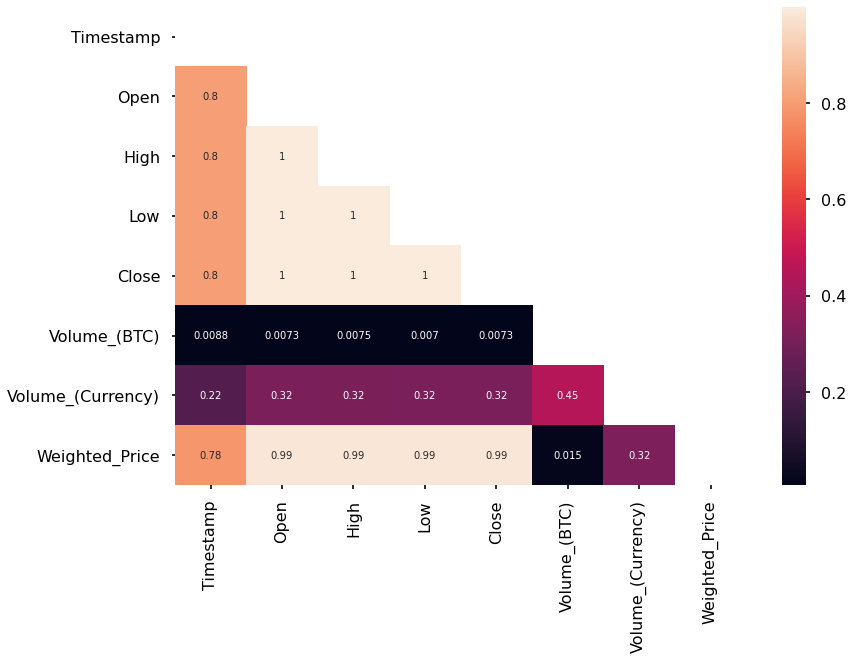

In [27]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
matrix = np.triu(df.corr())
sns.heatmap(df.corr(), annot=True, mask=matrix)

No handles with labels found to put in legend.


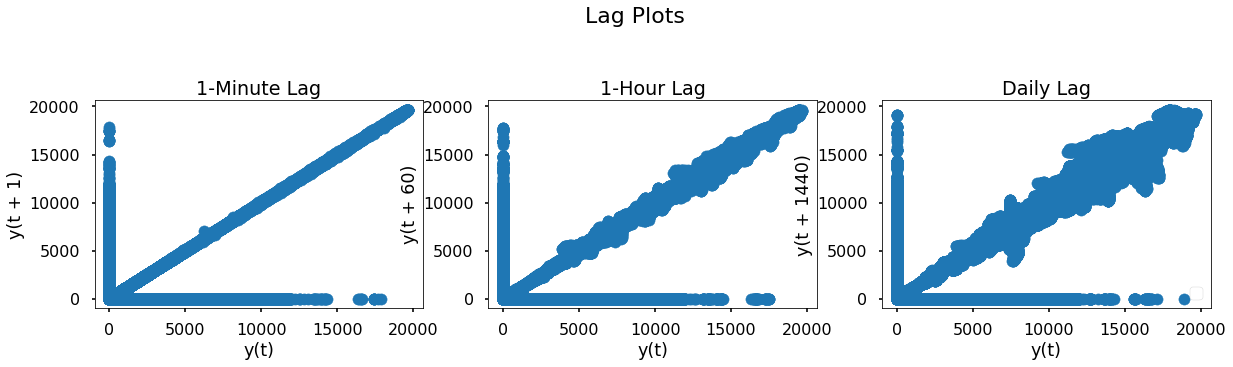

In [28]:
plt.figure(figsize=(20,13))
plt.suptitle('Lag Plots', fontsize=22)
#warnings.filterwarnings('ignore')

#lag in minutes
plt.subplot(3,3,1)
pd.plotting.lag_plot(df['Weighted_Price'], lag=1) #minute lag
plt.title('1-Minute Lag')

plt.subplot(3,3,2)
pd.plotting.lag_plot(df['Weighted_Price'], lag=60) #hourley lag
plt.title('1-Hour Lag')

plt.subplot(3,3,3)
pd.plotting.lag_plot(df['Weighted_Price'], lag=1440) #Daily lag
plt.title('Daily Lag')


plt.legend()
plt.show()

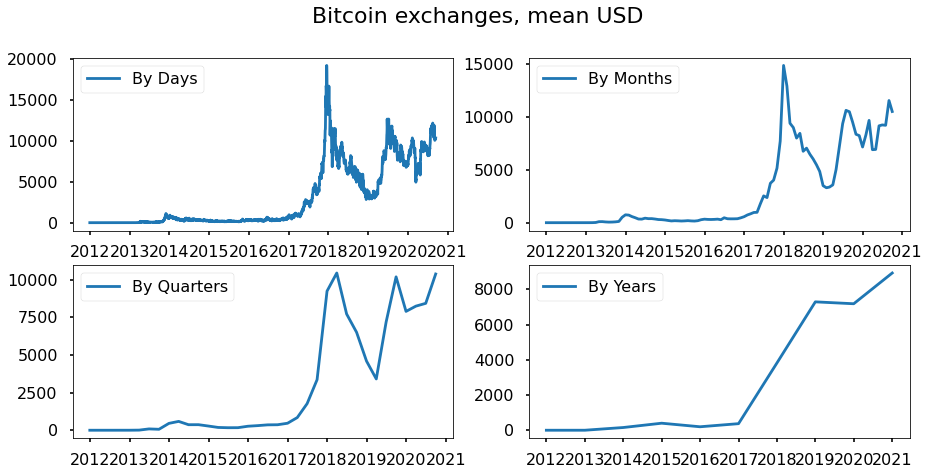

In [29]:
import seaborn as sns
import matplotlib as mpl
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product
from datetime import datetime
warnings.filterwarnings('ignore')
plt.style.use('seaborn-poster')
#df.Timestamp = pd.to_datetime(df.Timestamp, unit='s')
#df.index = df.Timestamp
df.Timestamp = pd.to_datetime(df.Timestamp, unit='s')
df.index = df.Timestamp
df = df.resample('D').mean()
df_month = df.resample('M').mean()
df_year = df.resample('A-DEC').mean()
df_Q = df.resample('Q-DEC').mean()


fig = plt.figure(figsize=[15, 7])
plt.suptitle('Bitcoin exchanges, mean USD', fontsize=22)

plt.subplot(221)
plt.plot(df.Weighted_Price, '-', label='By Days')
plt.legend()

plt.subplot(222)
plt.plot(df_month.Weighted_Price, '-', label='By Months')
plt.legend()

plt.subplot(223)
plt.plot(df_Q.Weighted_Price, '-', label='By Quarters')
plt.legend()

plt.subplot(224)
plt.plot(df_year.Weighted_Price, '-', label='By Years')
plt.legend()

# plt.tight_layout()
plt.show()

## Some Statistics !!

Dickey–Fuller test: p=0.746581


<Figure size 1080x504 with 0 Axes>

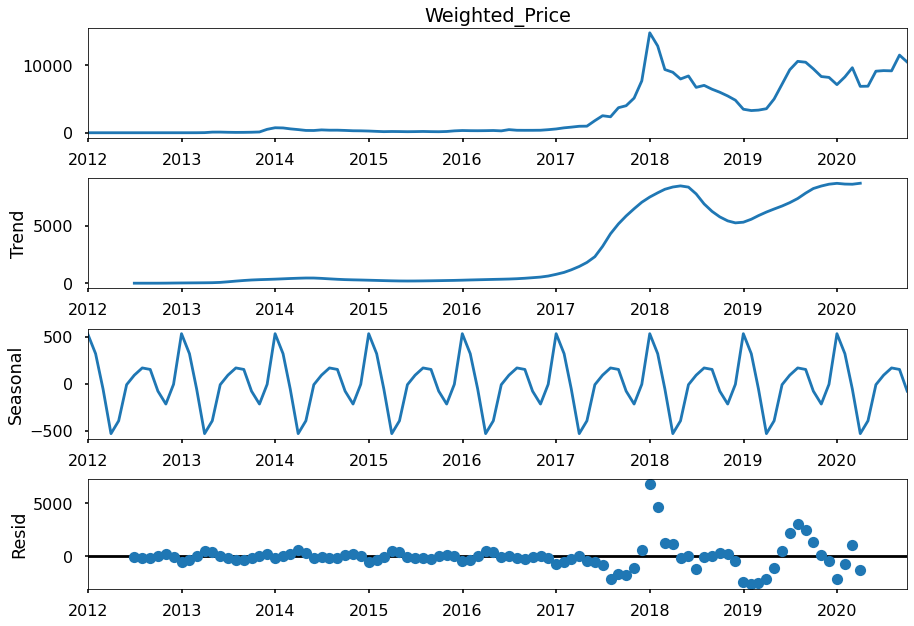

In [30]:
plt.figure(figsize=[15,7])
sm.tsa.seasonal_decompose(df_month.Weighted_Price).plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.Weighted_Price)[1])
plt.show()

In [31]:
df_month['Weighted_Price_box'], lmbda = stats.boxcox(df_month.Weighted_Price)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.Weighted_Price)[1])


Dickey–Fuller test: p=0.746581


In [32]:
df_month['prices_box_diff'] = df_month.Weighted_Price_box - df_month.Weighted_Price_box.shift(12)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.prices_box_diff[12:])[1])

Dickey–Fuller test: p=0.186309


In [33]:
#seasonl differencing
df_month['prices_box_diff'] = df_month.Weighted_Price_box - df_month.Weighted_Price_box.shift(12)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.prices_box_diff[12:])[1])

Dickey–Fuller test: p=0.186309


Dickey–Fuller test: p=0.000008


<Figure size 1080x504 with 0 Axes>

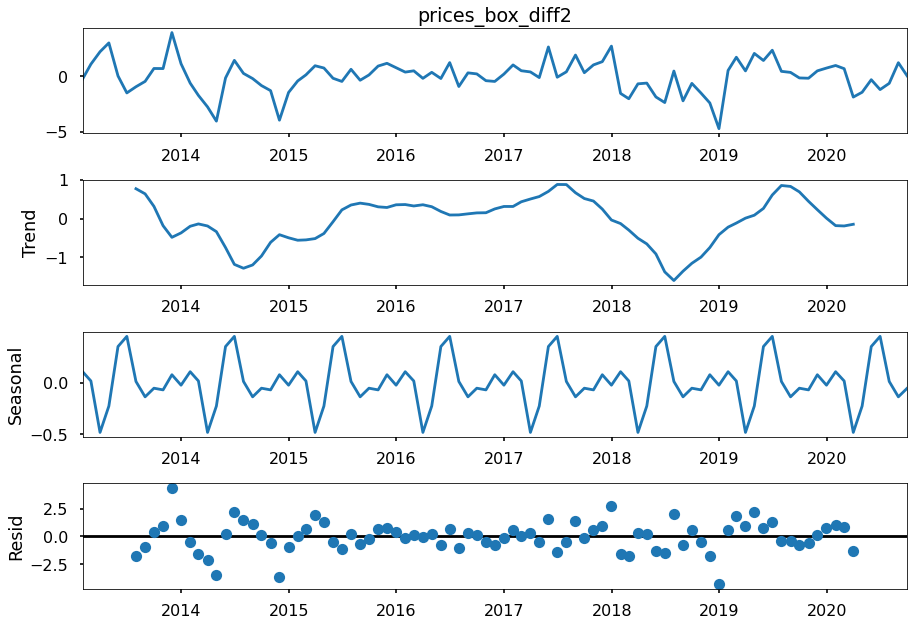

In [34]:
# Regular differentiation
df_month['prices_box_diff2'] = df_month.prices_box_diff - df_month.prices_box_diff.shift(1)
plt.figure(figsize=(15,7))

# STL-decomposition
sm.tsa.seasonal_decompose(df_month.prices_box_diff2[13:]).plot()   
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.prices_box_diff2[13:])[1])

plt.show()

In [35]:
# Initial approximation of parameters
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(df_month.Weighted_Price_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [36]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

      parameters         aic
19  (1, 0, 0, 1)  268.939082
7   (0, 1, 0, 1)  269.236607
21  (1, 0, 1, 1)  269.689214
9   (0, 1, 1, 1)  269.905340
23  (1, 0, 2, 1)  270.034472
                                      SARIMAX Results                                       
Dep. Variable:                   Weighted_Price_box   No. Observations:                  106
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -131.470
Date:                              Mon, 14 Dec 2020   AIC                            268.939
Time:                                      11:47:10   BIC                            276.537
Sample:                                  12-31-2011   HQIC                           272.007
                                       - 09-30-2020                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---

In [37]:
# Inverse Box-Cox Transformation Function
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

## Arima Model

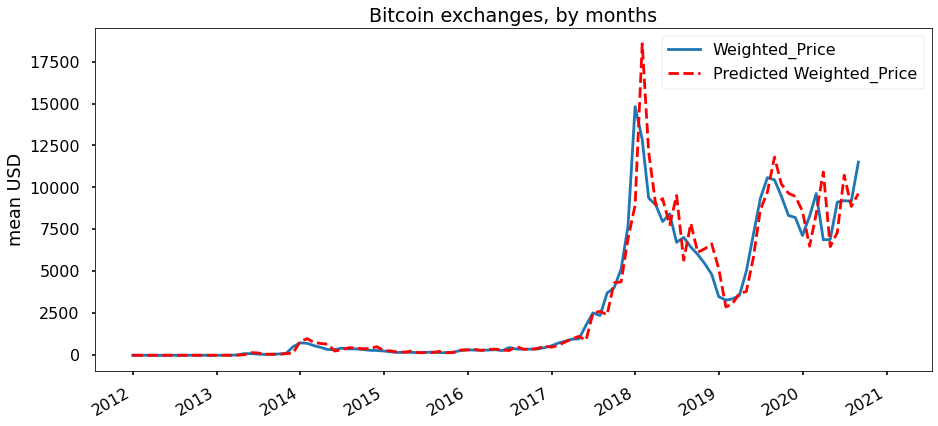

In [38]:
df_month2 = df_month[['Weighted_Price']]
date_list = [datetime(2020, 9,14), datetime(2020, 11, 3), datetime(2020, 12, 30), 
             datetime(2021, 1, 31), datetime(2021, 2 ,2),datetime(2021, 3,2), datetime(2021, 4,3),
             datetime(2021,5,8)
             ]

future = pd.DataFrame(index=date_list, columns= df_month.columns)
df_month2 = pd.concat([df_month2, future])
df_month2['forecast'] = invboxcox(best_model.predict(start=0, end=500),lmbda)
plt.figure(figsize=(15,7))
df_month2.Weighted_Price.plot()
df_month2.forecast.plot(color='r', ls='--', label='Predicted Weighted_Price')
plt.legend()
plt.title('Bitcoin exchanges, by months')
plt.ylabel('mean USD')
plt.show()

## Building LSTM

In [39]:
bit_data=pd.read_csv("dataset.csv")
bit_data["date"]=pd.to_datetime(bit_data["Timestamp"],unit="s").dt.date
group=bit_data.groupby("date")
data=group["Close"].mean()

In [40]:
data.shape

(3178,)

In [41]:
data.isnull().sum()

0

In [42]:
data.head()

date
2011-12-31    4.482500
2012-01-01    4.806667
2012-01-02    5.000000
2012-01-03    5.252500
2012-01-04    5.223333
Name: Close, dtype: float64

In [43]:
data.tail()

date
2020-09-10    10338.760864
2020-09-11    10302.451926
2020-09-12    10372.583252
2020-09-13    10392.960134
2020-09-14    10332.370000
Name: Close, dtype: float64

In [44]:
close_train=data.iloc[:len(data)-50]
close_test=data.iloc[len(close_train):]

In [45]:
#feature scalling (set values between 0-1)
close_train=np.array(close_train)
close_train=close_train.reshape(close_train.shape[0],1)
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
close_scaled=scaler.fit_transform(close_train)

In [46]:
timestep=50
x_train=[]
y_train=[]

for i in range(timestep,close_scaled.shape[0]):
    x_train.append(close_scaled[i-timestep:i,0])
    y_train.append(close_scaled[i,0])

x_train,y_train=np.array(x_train),np.array(y_train)
x_train=x_train.reshape(x_train.shape[0],x_train.shape[1],1) #reshaped for LSTM
print("x_train shape= ",x_train.shape)
print("y_train shape= ",y_train.shape)

x_train shape=  (3078, 50, 1)
y_train shape=  (3078,)


In [48]:
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout,Flatten

model=Sequential()

model.add(LSTM(10,input_shape=(None,1),activation="relu"))

model.add(Dense(1))

model.compile(loss="mean_squared_error",optimizer="adam",metrics=['accuracy'])

model.fit(x_train,y_train,epochs=100,batch_size=32,verbose=1)

Epoch 1/100
97/97 [==============================] - 5s 47ms/step - loss: 0.0321 - accuracy: 3.2489e-04
Epoch 2/100
97/97 [==============================] - 5s 47ms/step - loss: 0.0011 - accuracy: 6.4977e-04
Epoch 3/100
97/97 [==============================] - 4s 37ms/step - loss: 5.6996e-04 - accuracy: 6.4977e-04
Epoch 4/100
97/97 [==============================] - 4s 45ms/step - loss: 5.3961e-04 - accuracy: 6.4977e-04
Epoch 5/100
97/97 [==============================] - 5s 54ms/step - loss: 5.0856e-04 - accuracy: 6.4977e-04
Epoch 6/100
97/97 [==============================] - 4s 37ms/step - loss: 4.7175e-04 - accuracy: 6.4977e-04
Epoch 7/100
97/97 [==============================] - 4s 39ms/step - loss: 4.3504e-04 - accuracy: 6.4977e-04
Epoch 8/100
97/97 [==============================] - 4s 42ms/step - loss: 3.9742e-04 - accuracy: 6.4977e-04
Epoch 9/100
97/97 [==============================] - 4s 39ms/step - loss: 3.7406e-04 - accuracy: 6.4977e-04
Epoch 10/100
97/97 [================

In [49]:
inputs=data[len(data)-len(close_test)-timestep:]
inputs=inputs.values.reshape(-1,1)
inputs=scaler.transform(inputs)

In [50]:
x_test=[]
for i in range(timestep,inputs.shape[0]):
    x_test.append(inputs[i-timestep:i,0])
x_test=np.array(x_test)
x_test=x_test.reshape(x_test.shape[0],x_test.shape[1],1)

In [51]:
predicted_data=model.predict(x_test)
predicted_data=scaler.inverse_transform(predicted_data)

In [52]:
data_test=np.array(close_test)
data_test=data_test.reshape(len(data_test),1)

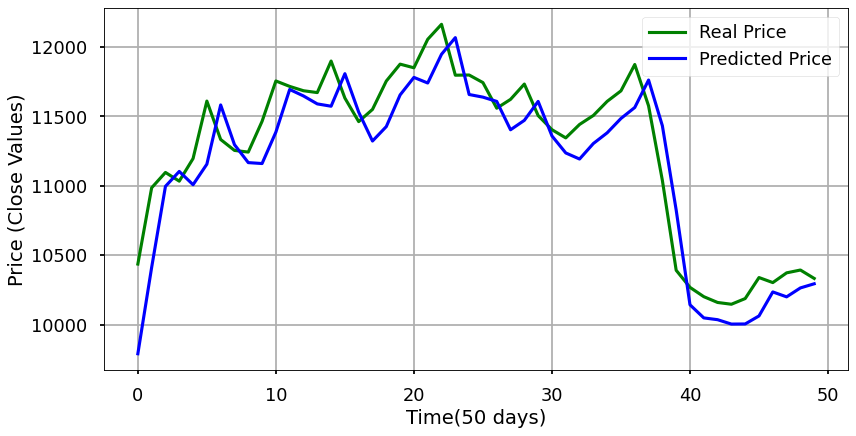

In [53]:
plt.figure(figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(data_test,color="g",label="Real Price")
plt.plot(predicted_data,color="b",label="Predicted Price")
plt.legend()
plt.xlabel("Time(50 days)")
plt.ylabel("Price (Close Values)")
plt.grid(True)
plt.show()

In [58]:
cvscores = []
scores = model.evaluate(x_test, data_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

accuracy: 0.00%
0.00% (+/- 0.00%)


## Stacked LSTM Model

In [60]:
import tensorflow as tf
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout,Flatten



model=Sequential()

model.add(LSTM(10,input_shape=(None,1),return_sequences=True))
model.add(LSTM(10, return_sequences=True))
#model.add(LSTM(10))
model.add(Dense(1))

model.compile(loss="mean_squared_error",optimizer="adam")

model.fit(x_train,y_train,epochs=100,batch_size=32)

Epoch 1/100
97/97 [==============================] - 8s 78ms/step - loss: 0.0155
Epoch 2/100
97/97 [==============================] - 7s 77ms/step - loss: 0.0071
Epoch 3/100
97/97 [==============================] - 8s 87ms/step - loss: 0.0061
Epoch 4/100
97/97 [==============================] - 7s 73ms/step - loss: 0.0056
Epoch 5/100
97/97 [==============================] - 8s 85ms/step - loss: 0.0052
Epoch 6/100
97/97 [==============================] - 8s 87ms/step - loss: 0.0049
Epoch 7/100
97/97 [==============================] - 9s 95ms/step - loss: 0.0047
Epoch 8/100
97/97 [==============================] - 8s 83ms/step - loss: 0.0045
Epoch 9/100
97/97 [==============================] - 8s 83ms/step - loss: 0.0043
Epoch 10/100
97/97 [==============================] - 8s 79ms/step - loss: 0.0042:
Epoch 11/100
97/97 [==============================] - 8s 82ms/step - loss: 0.0041: 
Epoch 12/100
97/97 [==============================] - 7s 77ms/step - loss: 0.0040
Epoch 13/100
97/97 [==

In [61]:
inputs=data[len(data)-len(close_test)-timestep:]
inputs=inputs.values.reshape(-1,1)
inputs=scaler.transform(inputs)

x_test=[]
for i in range(timestep,inputs.shape[0]):
    x_test.append(inputs[i-timestep:i,0])
x_test=np.array(x_test)
x_test=x_test.reshape(x_test.shape[0],x_test.shape[1],1)

In [62]:
predicted_data=model.predict(x_test)
print(predicted_data.shape)

predicted_data=scaler.inverse_transform(predicted_data)

data_test=np.array(close_test)
data_test=data_test.reshape(len(data_test),1)

(50, 50, 1)


ValueError: Found array with dim 3. Estimator expected <= 2.

In [ ]:
plt.figure(figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(data_test,color="g",label="Real Price")
plt.plot(predicted_data,color="b",label="Predicted Price")
plt.legend()
plt.xlabel("Time(50 days)")
plt.ylabel("Price (Close Values)")
plt.grid(True)
plt.show()

In [ ]:
#prediction using svm
data=pd.read_csv("CBBTCUSD.csv")

In [ ]:
data.head(7)

In [ ]:
data.tail()

In [ ]:
data.drop(['DATE'], 1, inplace=True)

In [ ]:
data.head()

In [ ]:
prediction_days = 30
data['Prediction'] = data[['CBBTCUSD']].shift(-prediction_days)

In [ ]:
data.head(7)

In [ ]:
data.tail(7)

In [ ]:
X = np.array(data.drop(['Prediction'],1))
X= X[:len(data)-prediction_days]
print(X)

In [ ]:
y = np.array(data['Prediction'])  
y = y[:-prediction_days] 
print(y)

In [ ]:
# Split the data into 80% training and 20% testing
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
# Set prediction_days_array equal to the last 30 rows of the original data set from the price column
prediction_days_array = np.array(data.drop(['Prediction'],1))[-prediction_days:]
print(prediction_days_array)

In [ ]:
from sklearn.svm import SVR
# Create and train the Support Vector Machine 
svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.00001)#Create the model
svr_rbf.fit(x_train, y_train) #Train the model

In [ ]:
# Testing Model: Score returns the accuracy of the prediction. 
# The best possible score is 1.0
svr_rbf_confidence = svr_rbf.score(x_test, y_test)
print("svr_rbf accuracy: ", svr_rbf_confidence)

In [ ]:
# Print the predicted value
svm_prediction = svr_rbf.predict(x_test)
print(svm_prediction)

print()

#Print the actual values
print(y_test)

In [ ]:
# Print the model predictions for the next 'n=30' days
svm_prediction = svr_rbf.predict(prediction_days_array)
print(svm_prediction)

In [ ]:
#Print the actual price for the next 'n' days, n=prediction_days=30 
data.tail(prediction_days)

In [ ]:
plt.plot(data)